# CM1
**Note: Important section have** <span style="color:blue">**blue**</span> **heading**

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, Embedding, Input
from keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# defining function for plotting correlation heatmap
def plot_heatmap(correlation, title):
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(correlation,annot=True,fmt='.3f',linewidths=0.3,annot_kws={"size": 18})
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.title(title, fontsize=20)
    ax.figure.axes[-1].tick_params(labelsize=18) # To increase fontsize of colorbar ticks
    #lim = len(correlation.columns)
    #ax.set_ylim([0,lim]) # to make the map display correctly without trimming the edges
    plt.show()
    return

In [4]:
def accuracy_loss_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper right')

In [5]:
def compare_accuracy_loss(history_list):
    n_models = len(history_list)
    fig, axs = plt.subplots(n_models, 2, figsize=(10, 16))

    for i in range(n_models):
        title = 'Model ' + str(i+1)
        axs[i, 0].plot(history_list[i].history['accuracy'])
        axs[i, 0].plot(history_list[i].history['val_accuracy'])
        axs[i, 0].legend(['Train', 'Val'], loc='lower right')
        axs[i, 0].set_title(title , y=1.0, pad=-60)
        axs[i, 0].set(ylabel='Accuracy')
        axs[i, 1].plot(history_list[i].history['loss'])
        axs[i, 1].plot(history_list[i].history['val_loss'])
        axs[i, 1].legend(['Train', 'Val'], loc='upper right')
        axs[i, 1].set_title(title, y=1.0, pad=-60)
        axs[i, 1].set(ylabel='Loss')

    for i in range((n_models * 2) - 2, n_models * 2):
        axs.flat[i].set(xlabel='Epoch')

In [6]:
def print_accuracy(model, y_train, y_val, y_test, mode = 0):
    global X_train, X_val, X_test
    global rnn_train, rnn_val, rnn_test
    
    if mode == 0:
        y_pred_train = np.argmax(model.predict(X_train), axis=-1)
        y_pred_val = np.argmax(model.predict(X_val), axis=-1)
        y_pred_test = np.argmax(model.predict(X_test), axis=-1)
    else:
        y_pred_train = np.argmax(model.predict(rnn_train), axis=-1)
        y_pred_val = np.argmax(model.predict(rnn_val), axis=-1)
        y_pred_test = np.argmax(model.predict(rnn_test), axis=-1)
    
    preds = [y_pred_train, y_pred_val, y_pred_test]
    trues = [y_train, y_val, y_test]
    
    tag = ['Train', 'Val', 'Test']
    
    for i in range(3):
        accuracy = accuracy_score(trues[i], preds[i])
        metric = list(precision_recall_fscore_support(trues[i], preds[i], average='macro'))
        print(tag[i], 'Set Accuracy: \t', round(accuracy * 100, 2))
        print(tag[i], 'Set Precision: \t', round(metric[0], 2))
        print(tag[i], 'Set Recall: \t', round(metric[1], 2))
        print(tag[i], 'Set F score: \t', round(metric[2], 2))
        print()

In [7]:
# importing the dataset
dataset = pd.read_csv('COVID_dataset.csv')

In [8]:
dataset.shape

(14860, 12)

In [9]:
dataset.head(10)

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
5,2021-01-17,2021-01-19,2021-01-19,2021-01-18,50s,FEMALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
6,2021-01-23,2021-01-24,2021-01-24,2021-01-23,20s,MALE,MISSING INFORMATION,Ottawa,NaN,45.345665,-75.763912,Not Resolved
7,2021-01-06,2021-01-20,2021-01-20,2021-01-19,80s,FEMALE,OB,Waterloo,Yes,43.462876,-80.520913,Resolved
8,2021-01-25,2021-01-29,2021-01-29,2021-01-28,40s,MALE,CC,Newmarket,NaN,44.048023,-79.480239,Not Resolved
9,2020-12-07,2020-12-11,2020-12-11,2020-12-07,90s,MALE,OB,Hamilton,Yes,43.257631,-79.871341,Fatal


## Data Cleaning

In [10]:
# checking for missing values in columns
for column in dataset.columns:
    print(column, "-", dataset[column].isna().sum())

Accurate_Episode_Date - 0
Case_Reported_Date - 0
Test_Reported_Date - 203
Specimen_Date - 122
Age_Group - 5
Client_Gender - 0
Case_AcquisitionInfo - 0
Reporting_PHU_City - 0
Outbreak_Related - 9082
Reporting_PHU_Latitude - 0
Reporting_PHU_Longitude - 0
Outcome1 - 0


In [11]:
# filling missing values in outbreak related with NO
dataset["Outbreak_Related"].fillna("No", inplace=True)

In [12]:
# drop missing columns in Age_Group
dataset = dataset[dataset['Age_Group'].notna()]
dataset.reset_index(drop=True, inplace=True)

In [13]:
data = dataset[dataset['Case_Reported_Date'] == dataset['Test_Reported_Date']]
data.shape

(13757, 12)

In [14]:
# grouping features accourding to their data types
dates = ['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date']
cats = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']
nums = ['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
ords = ['Age_Group']
target = ['Outcome1']

In [ ]:
# inspecting the unique values in categorical columns and their frequencies
for column in cats:
    print(column)
    print(dataset[column].value_counts())
    print()

In [16]:
# Assigning numeric labels to ordinal data for data exploration
dataset['Age_Group'].replace(["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],[0,1,2,3,4,5,6,7,8], inplace = True)

In [17]:
# Label encoding the outcomes
outcomes = ["Resolved", "Not Resolved", "Fatal"]
dataset['Outcome1'].replace(["Resolved", "Not Resolved", "Fatal"],[0,1,2], inplace = True)

In [18]:
# Grouping some of the sparse categories
dataset["Client_Gender"].replace(['UNSPECIFIED', 'GENDER DIVERSE'], 'OTHER', inplace = True)
dataset["Case_AcquisitionInfo"].replace(['TRAVEL', 'UNSPECIFIED EPI LINK'], 'OTHER', inplace = True)

#### Engineering the date colums
The date columns can be converted to the number of days passed since January 1, 2020 since COVID 19 started in 2020 and there cant be earlier case dates.

In [19]:
# convert the dates from float to datetime objects
for column in dates:
    dataset[column] = (pd.to_datetime(dataset[column], format = '%Y-%m-%dT', errors = 'coerce')- datetime(2020, 1, 1)).dt.days

In [20]:
# fill missing values in dates with mean
date_means = {}
for column in dates:
    date_means[column] = dataset[column].mean()
    dataset[column].fillna(dataset[column].mean(), inplace=True)

In [21]:
dataset.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,89,90,90.0,89.0,6,MALE,OB,Stratford,Yes,43.368662,-81.001913,2
1,387,389,389.0,388.0,4,FEMALE,NO KNOWN EPI LINK,Newmarket,No,44.048023,-79.480239,1
2,83,104,104.0,103.0,6,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,0
3,383,386,386.0,383.0,0,MALE,CC,Mississauga,No,43.647471,-79.708893,1
4,360,362,362.0,360.0,5,MALE,OB,Windsor,Yes,42.308796,-83.033670,0


## Exploratrory Data Analysis

##### Plotting the pairs plot for numeric features

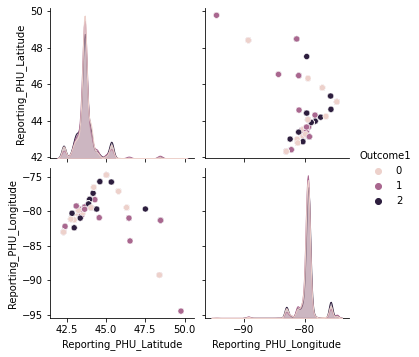

In [22]:
sns.pairplot(dataset[['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1']], hue="Outcome1")

#### Checking the correlation for numerical features

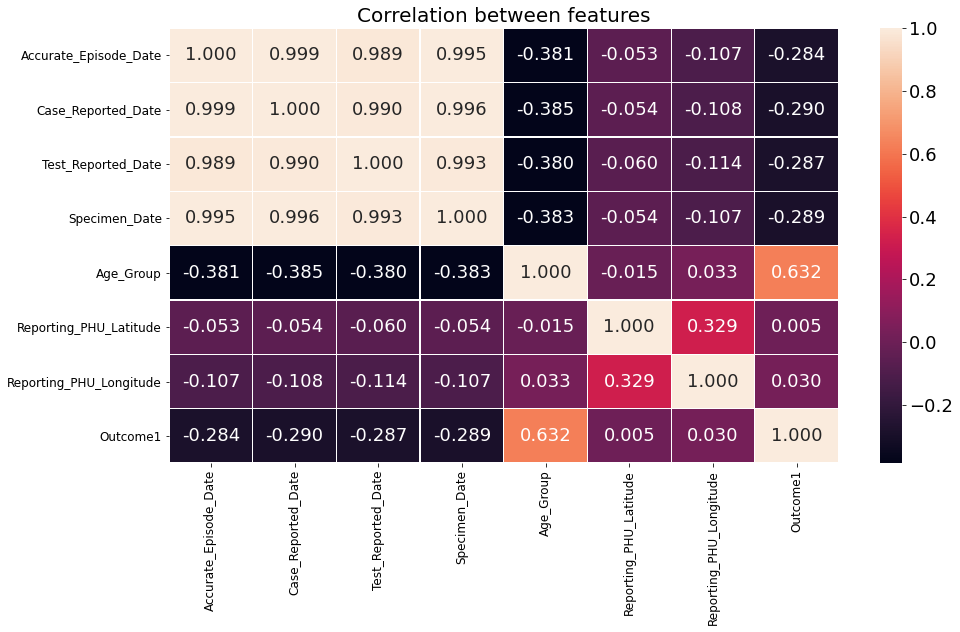

In [23]:
plot_heatmap(dataset.corr(), 'Correlation between features')

### <span style="color:blue">Observations from correlation heatmap of numeric and ordinal features </span> 

- The dates have the highest negative correlation with the outcome but also have high interfeature correlation and bring concerns of multicollinearity.
- Age group has the highest positive correlation with the outcome (0.632)
- latitude and longitude have low correlation with the outcome.

### Checking the correlations of categorical features using Cramer's V method

Cramér’s V is substitute for correlation which is suitable for categorical variables. It is based on a nominal variation of Pearson’s Chi-Square Test.

1. Just like correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t).

2. Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

In [24]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [25]:
for column1 in cats:
    print(column1, '-', 'Outcome = ', round(cramers_v(dataset[column1], dataset['Outcome1']), 3))
    for column2 in cats:
        print(column1, '-', column2, '=', round(cramers_v(dataset[column1], dataset[column2]), 3))
    print()

Client_Gender - Outcome =  0.021
Client_Gender - Client_Gender = 1.0
Client_Gender - Case_AcquisitionInfo = 0.078
Client_Gender - Reporting_PHU_City = 0.048
Client_Gender - Outbreak_Related = 0.107

Case_AcquisitionInfo - Outcome =  0.416
Case_AcquisitionInfo - Client_Gender = 0.078
Case_AcquisitionInfo - Case_AcquisitionInfo = 1.0
Case_AcquisitionInfo - Reporting_PHU_City = 0.292
Case_AcquisitionInfo - Outbreak_Related = 0.919

Reporting_PHU_City - Outcome =  0.15
Reporting_PHU_City - Client_Gender = 0.048
Reporting_PHU_City - Case_AcquisitionInfo = 0.292
Reporting_PHU_City - Reporting_PHU_City = 1.0
Reporting_PHU_City - Outbreak_Related = 0.206

Outbreak_Related - Outcome =  0.535
Outbreak_Related - Client_Gender = 0.107
Outbreak_Related - Case_AcquisitionInfo = 0.919
Outbreak_Related - Reporting_PHU_City = 0.206
Outbreak_Related - Outbreak_Related = 1.0



### <span style="color:blue">Observations from Cramer's V coefficients of categorical features </span> 

- Outbreak Related has a the most significant relationship with the outcome (0.535).
- Case_AcquisitionInfo also has a significant relationship with the outcome (0.416).
- Client Gender has the least correlation with the outcome.
- Case_AcquisitionInfo and Outbreak Related have the highest inter-feature relationship (0.919) which is logical as they both describe how the virus was contacted.

##### Calculating the mean, variance, skew, kurtosis for the datasets

In [26]:
# comparing for the different outcome
for outcome in dataset["Outcome1"].unique():
    print("*** Outcome = ", outcomes[outcome], "***")
    columns = nums + ords
    for column in columns:
        
        mean = round(dataset[dataset['Outcome1'] == outcome][column].mean(), 2)
        variance = round(dataset[dataset['Outcome1'] == outcome][column].var(), 2)
        skew = round(dataset[dataset['Outcome1'] == outcome][column].skew(), 2)
        kurtosis = round(dataset[dataset['Outcome1'] == outcome][column].kurt(), 2)
        
        # if column is not numeric find the mode
        if column in cats or column in ords:
            mode = round(dataset[dataset['Outcome1'] == outcome][column].mode()[0], 2)
            print(column, "Mode -", mode)
        else:
            print(column, "Mean -", mean)
            
        print(column, "Variance -", variance)
        print(column, "Skew -", skew)
        print(column, "Kurtosis -", kurtosis)
        print()

*** Outcome =  Fatal ***
Reporting_PHU_Latitude Mean - 43.72
Reporting_PHU_Latitude Variance - 0.55
Reporting_PHU_Latitude Skew - 2.01
Reporting_PHU_Latitude Kurtosis - 9.81

Reporting_PHU_Longitude Mean - -79.48
Reporting_PHU_Longitude Variance - 2.63
Reporting_PHU_Longitude Skew - -0.31
Reporting_PHU_Longitude Kurtosis - 6.4

Age_Group Mode - 7
Age_Group Variance - 1.33
Age_Group Skew - -1.19
Age_Group Kurtosis - 1.97

*** Outcome =  Not Resolved ***
Reporting_PHU_Latitude Mean - 43.75
Reporting_PHU_Latitude Variance - 0.62
Reporting_PHU_Latitude Skew - 3.23
Reporting_PHU_Latitude Kurtosis - 16.73

Reporting_PHU_Longitude Mean - -79.63
Reporting_PHU_Longitude Variance - 2.41
Reporting_PHU_Longitude Skew - -1.84
Reporting_PHU_Longitude Kurtosis - 19.26

Age_Group Mode - 1
Age_Group Variance - 4.52
Age_Group Skew - 0.5
Age_Group Kurtosis - -0.55

*** Outcome =  Resolved ***
Reporting_PHU_Latitude Mean - 43.72
Reporting_PHU_Latitude Variance - 0.48
Reporting_PHU_Latitude Skew - 2.5
Repo

###  <span style="color:blue"> Nature of the data and observations </span>

- The most frequently occuring age group in the Resolved and Not Resolved Outcomes is 20s, while the mode age group for the Fatal Outcome is 80s.
- The mean latitude and longitude for all outcomes are similar.
- for all outcomes, Longitude is left skewed while Latitude is right skewed.

In [27]:
# Assigning numeric labels to categorical data for data exploration
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data = dataset.copy()
for column in cats:
    data[column] = le.fit_transform(data[column])

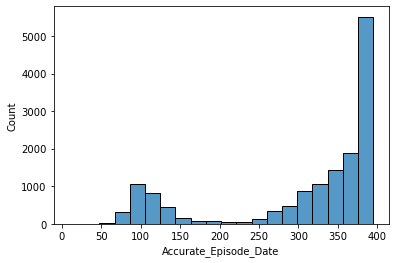

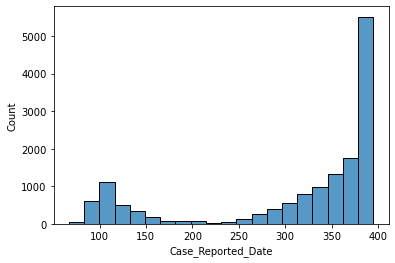

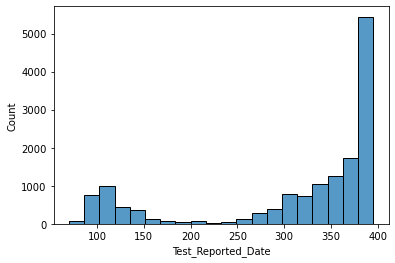

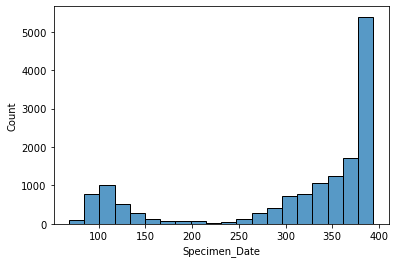

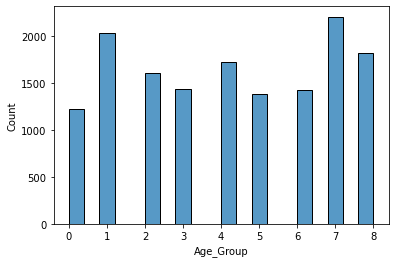

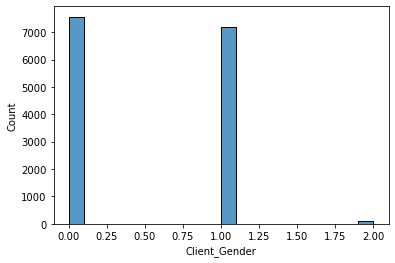

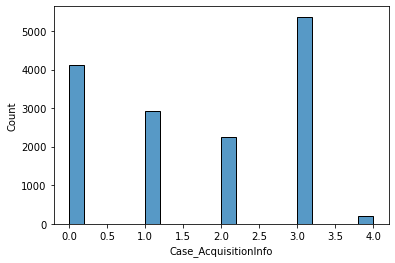

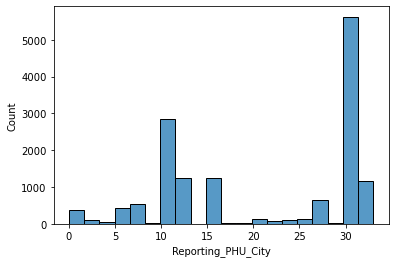

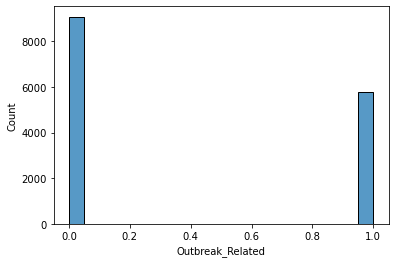

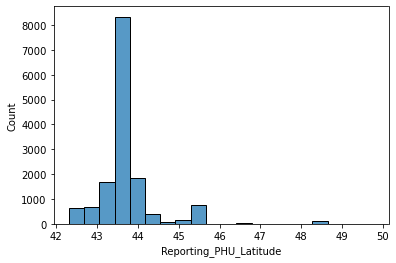

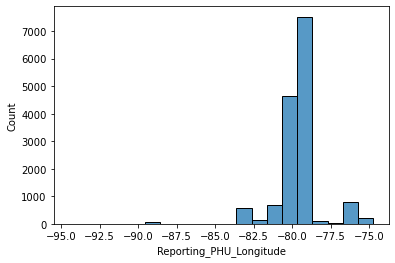

In [28]:
# Plotting histogram to view data distribution
for column in data.iloc[:,:-1].columns:
    plt.figure()
    sns.histplot(data = data, x = column, bins = 20)
    plt.show()

### <span style="color:blue">Notes about Histogram</span>

- All categorical variables are in the right range without outliers.
- Reporting_PHU_Latitude and Reporting_PHU_Longitude both seem to have outliers.
- The histogram plots of the dates show the exponential increase in Covid 19 cases.

#### Plotting histogram grouped by the different outcomes

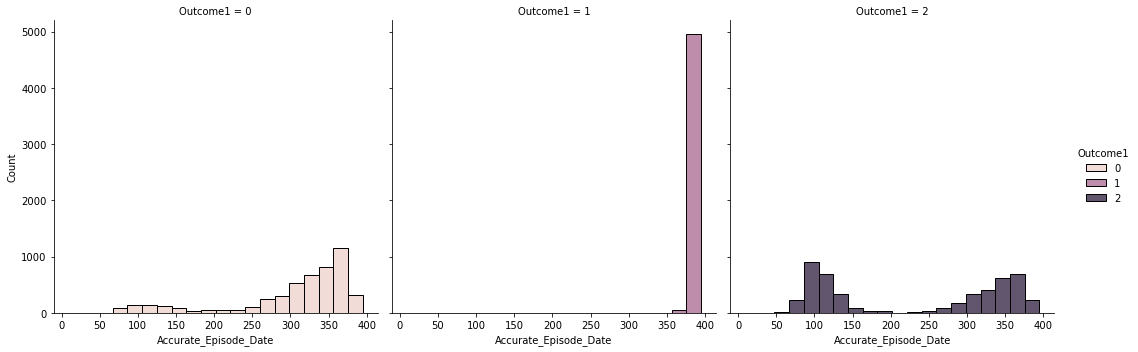

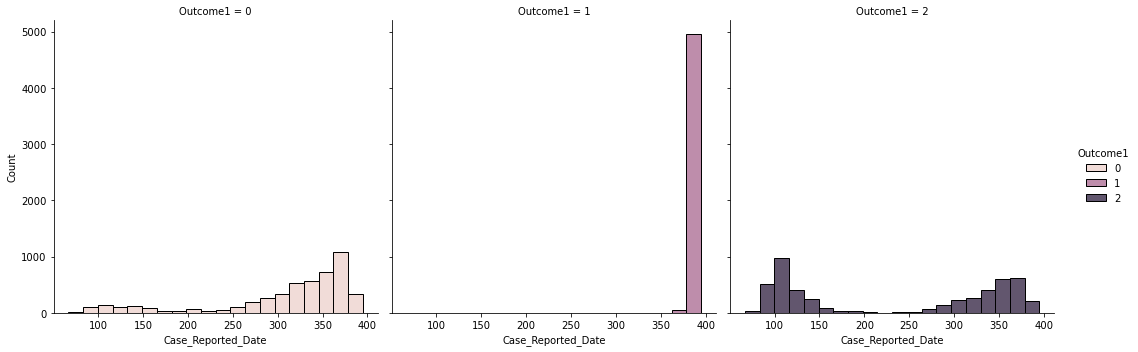

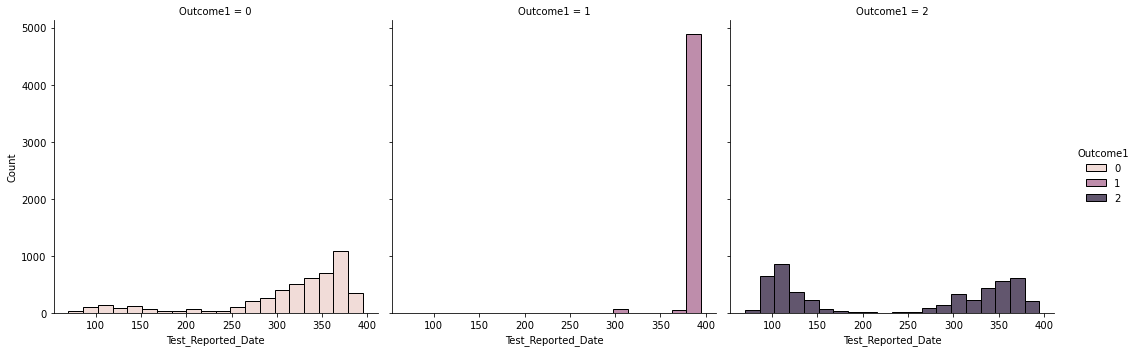

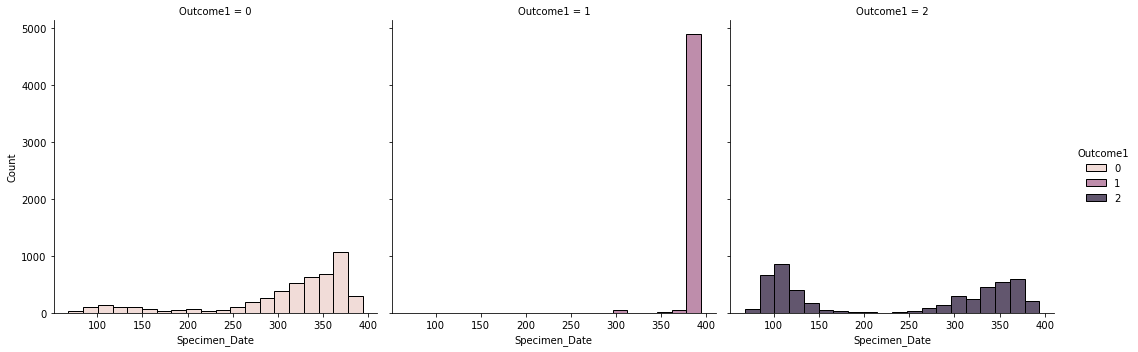

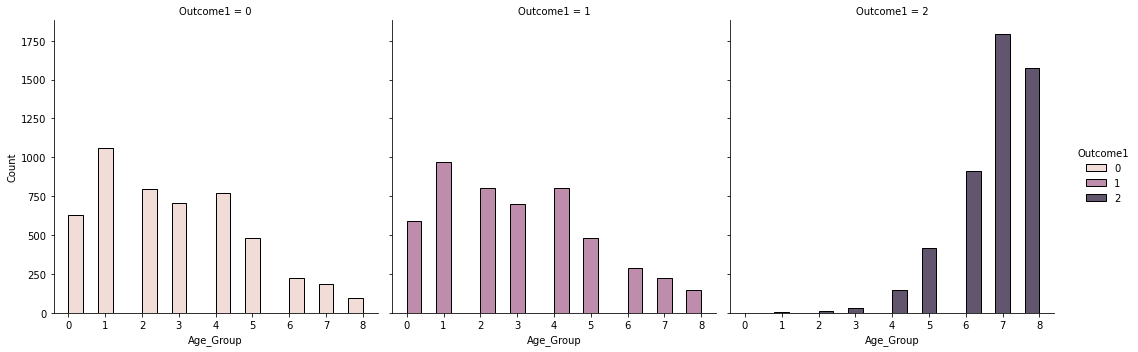

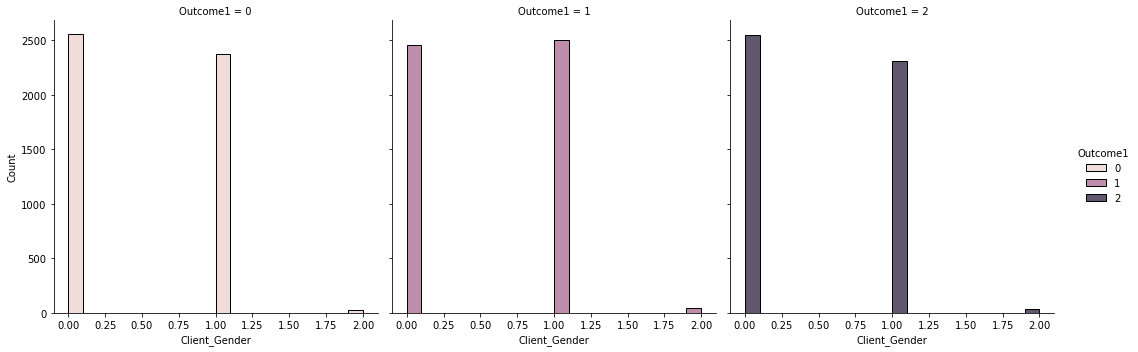

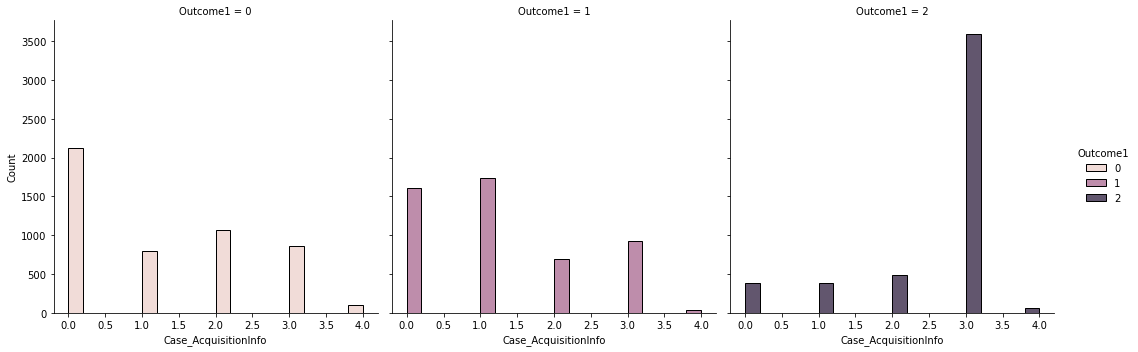

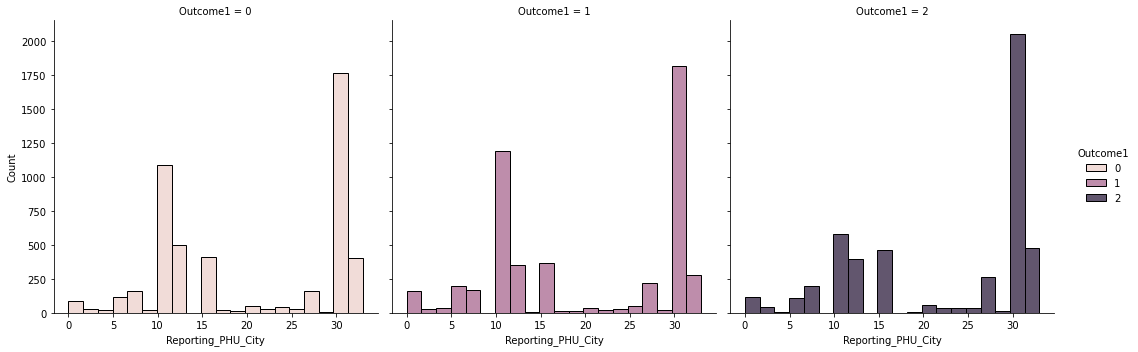

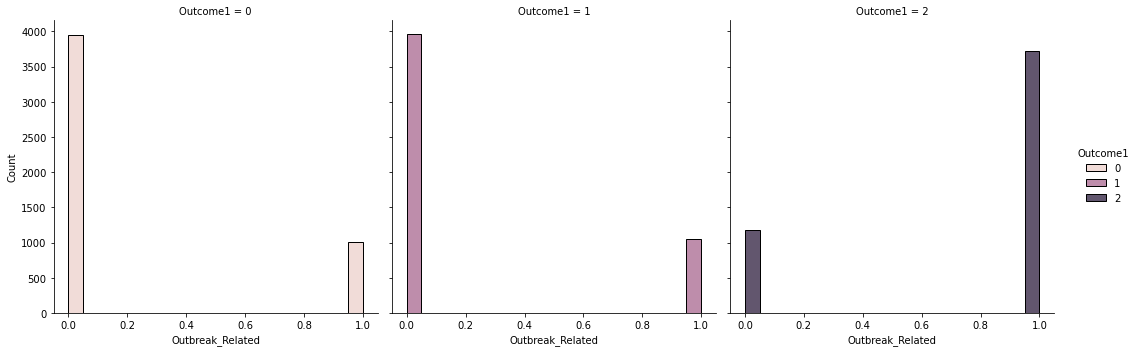

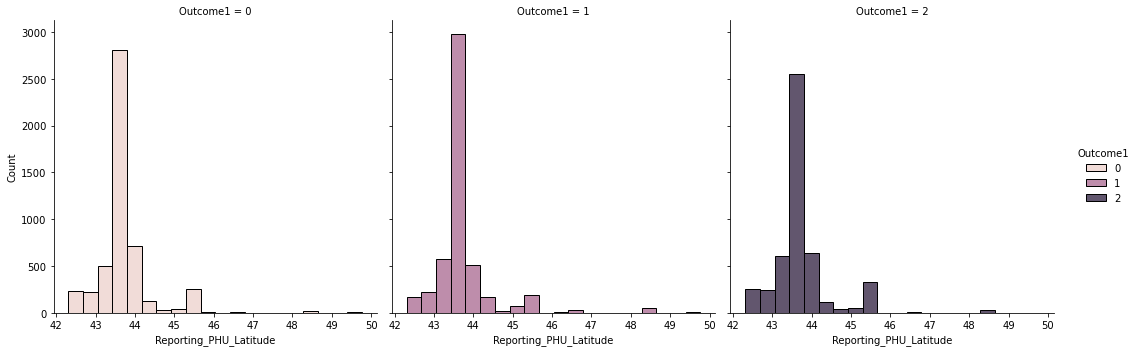

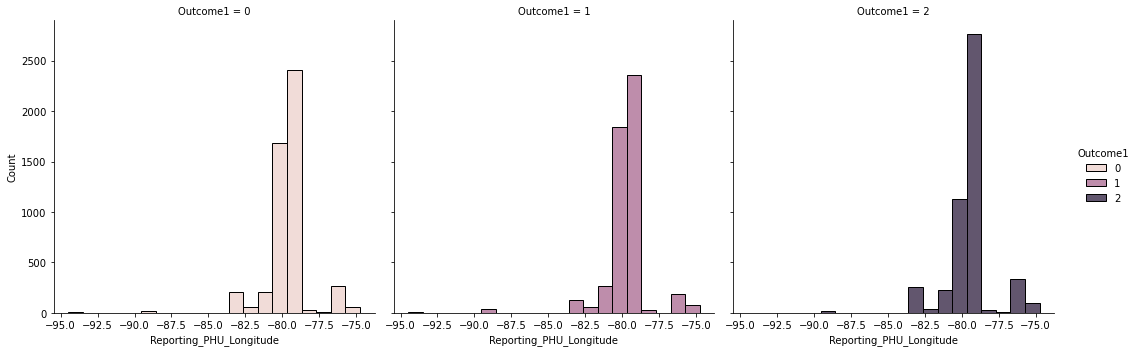

In [29]:
# plotting the histogram to view data distribution by outcome
for feature in data.columns[:-1]:
    sns.displot(data, x = feature, bins = 20, col = 'Outcome1', hue = 'Outcome1')

#### <span style="color:blue">Nature of the data and observations</span>

- For Age Group, most of people older than 70 have a fatal outcome while most people less than 40 have either Resolved or Unresolved outcomes.
- The distributions for Client Gender, Outbreak Related and Reporting_PHU_City are very similar for all three Outcomes
- In the Case Acquisition Info, most of the causes caused by outbreak resulted in a fatal outcome.
- Most cases which were outbreak related had a fatal outcome.
- Most cases 360 to 450 days after 01-01-2020 are unresolved

In [31]:
df = pd.get_dummies(dataset.iloc[:,:-1], columns = cats, drop_first = True)
df["Outcome1"] = dataset["Outcome1"]
dataset = df

dataset.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_MALE,Client_Gender_OTHER,Case_AcquisitionInfo_MISSING INFORMATION,...,Reporting_PHU_City_Sudbury,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_Yes,Outcome1
0,89,90,90.0,89.0,6,43.368662,-81.001913,1,0,0,...,0,0,0,0,0,0,0,0,1,2
1,387,389,389.0,388.0,4,44.048023,-79.480239,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,83,104,104.0,103.0,6,43.656591,-79.379358,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,383,386,386.0,383.0,0,43.647471,-79.708893,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,360,362,362.0,360.0,5,42.308796,-83.033670,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [ ]:
df = dataset.iloc[:,:]
df.head()

In [33]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [34]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [35]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [36]:
X_train.shape

(11884, 47)

In [37]:
y_train.shape

(11884,)

## <span style="color:blue">Building The Fully Connected Deep Neural Networks</span>

### <span style="color:blue">Network description</span>

We built 4 fully connected neural network models using various architectures but all training was done with a batch size of **64** and **100** epochs. Batch size determines the number of training samples in one forward or backward pass. Although, smaller batch sizes (<10) offer a regularizing effect and lower generalization error, they can be noisy.  Higher batch sizes lead to lower asymptotic test accuracy. Considering these effects, a batch size of 64 was chosen. 

Also, **softmax** activation was used for all the output layers as the the problem is a multiclass classification and softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1.

The loss function used for all models was **SparseCategoricalCrossentropy** which is excellent for multiclass labels in floating point format.

The two main activation functions used are **sigmoid** and **relu** and they both have their advantages and disadvantages
- Sigmoid does not blow up activation unlike Relu which has no mechanism to constrain the output of the neurons.
- Relu prevents the vanishing gradient problem so networks can go deeper unlike Sigmoid which is prone to gradient vanishing
- Relu is also more computationally efficient to compute compared to Sigmoid as Relu just to picks max(0, x) and does not perform expensive exponential operations as in Sigmoid

With deeper networks, problem of overfitting and vanishing gradients become a concern. The regularization method used was **dropout** method which randomly ignores certain units during training thus leading to units that specialize. It reduces overfitting by encouraging robustness of weights.

- The **first model** is a 4 layer fully connected Neural Network (1 input layer, 2 hidden layers with relu activation function, 1 output layer).
- The **second model** is a 4 layer fully connected Neural Network (1 input layer, 2 hidden layers with sigmoid activation function, 1 output layer).
- The **third model** is a 6 layer fully connected Neural Network (1 input layer, 4 hidden layers with relu activation function, 1 output layer).
- The **fourth model** is an 8 layer fully connected Neural Network (1 input layer, 4 hidden layers with relu activation function, 2 dropout layers to prevent overfitting and 1 output layer).

### <span style="color:blue">Model 1: 1 input layer, 2 hidden layers with relu activation and 1 output layer</span>

#### Building and training the model

In [38]:
model_1 = Sequential()

# Creating the input layer and first hidden layer
model_1.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))

#Adding second hidden layer
model_1.add(Dense(24, activation='relu'))

#Adding the output layer
model_1.add(Dense(3, activation='softmax'))

#Compiling the ANN
model_1.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

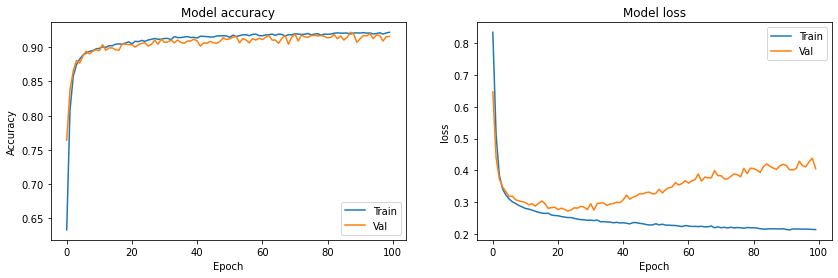

In [40]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set but from the loss plots, the model has comparatively higher losses on the validation set compared to the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is an 4 layer fully connected Neural Network. it has 1 input layer, 2 hidden layers with Relu activation function and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

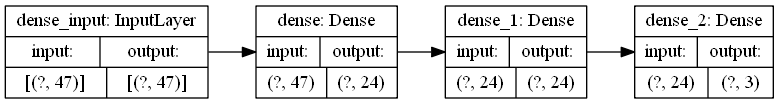

In [41]:
plot_model(model_1, show_shapes=True, rankdir="LR")

In [42]:
print(model_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75        
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________
None


#### Evaluating the model on the test set

In [43]:
%%time
y_pred_test = np.argmax(model_1.predict(X_test), axis=-1)

Wall time: 116 ms


In [44]:
print_accuracy(model_1, y_train, y_val, y_test)

Train Set Accuracy: 	 92.34
Train Set Precision: 	 0.92
Train Set Recall: 	 0.92
Train Set F score: 	 0.92

Val Set Accuracy: 	 91.58
Val Set Precision: 	 0.92
Val Set Recall: 	 0.92
Val Set F score: 	 0.92

Test Set Accuracy: 	 91.05
Test Set Precision: 	 0.91
Test Set Recall: 	 0.91
Test Set F score: 	 0.91



In [45]:
history_list = []
history_list.append(history)

### <span style="color:blue">Model 2: 1 input layer, 2 hidden layers with sigmoid activation and 1 output layer</span>

#### Building and training the model

In [46]:
model_2 = Sequential()

# Creating the input layer and first hidden layer
model_2.add(Dense(24, input_dim=X_train.shape[1], activation='sigmoid'))

#Adding second hidden layer
model_2.add(Dense(24, activation='sigmoid'))

#Adding the output layer
model_2.add(Dense(3, activation='softmax'))

#Compiling the ANN
model_2.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_2.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

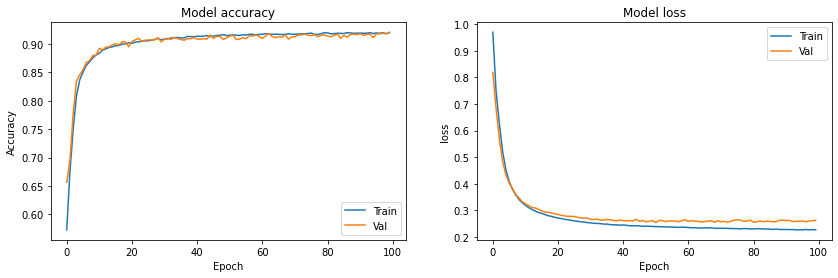

In [48]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set. The loss plot also shows that the model performs as well on the validation set as it does on the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is an 4 layer fully connected Neural Network. it has 1 input layer, 2 hidden layers with Sigmoid activation function and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

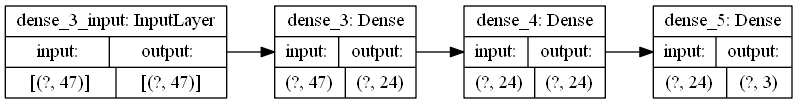

In [49]:
plot_model(model_2, show_shapes=True, rankdir="LR")

In [50]:
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 24)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 75        
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________
None


#### Evaluating the model on the test set

In [51]:
%%time
y_pred_test = np.argmax(model_2.predict(X_test), axis=-1)

Wall time: 97.8 ms


In [52]:
print_accuracy(model_2, y_train, y_val, y_test)

Train Set Accuracy: 	 92.21
Train Set Precision: 	 0.92
Train Set Recall: 	 0.92
Train Set F score: 	 0.92

Val Set Accuracy: 	 92.05
Val Set Precision: 	 0.92
Val Set Recall: 	 0.92
Val Set F score: 	 0.92

Test Set Accuracy: 	 91.25
Test Set Precision: 	 0.91
Test Set Recall: 	 0.91
Test Set F score: 	 0.91



In [53]:
history_list.append(history)

### <span style="color:blue">Model 3: Making the network deeper - 1 input layer, 4 hidden layers with relu activation and 1 output layer</span>

#### Building and training the model

In [54]:
model_3 = Sequential()

# Creating the input layer and first hidden layer
model_3.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))

#Adding second hidden layer
model_3.add(Dense(24, activation='relu'))

#Adding third hidden layer
model_3.add(Dense(24, activation='relu'))

#Adding fourth hidden layer
model_3.add(Dense(24, activation='relu'))

#Adding the output layer
model_3.add(Dense(3, activation='softmax'))

#Compiling the ANN
model_3.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_3.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

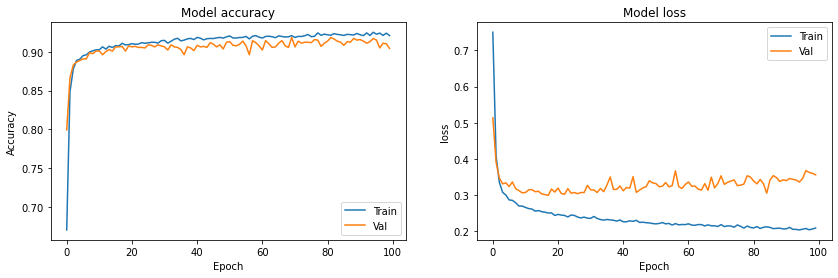

In [56]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set but from the loss plots, the model has comparatively higher losses on the validation set compared to the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is an 6 layer fully connected Neural Network. it has 1 input layer, 4 hidden layers with Relu activation function and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

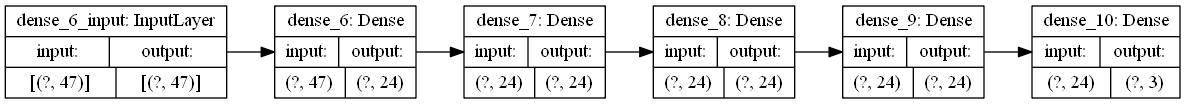

In [57]:
plot_model(model_3, show_shapes=True, rankdir="LR")

In [58]:
print(model_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                1152      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 75        
Total params: 3,027
Trainable params: 3,027
Non-trainable params: 0
_________________________________________________________________
None


#### Evaluating the model on the test set

In [59]:
%%time
y_pred_test = np.argmax(model_3.predict(X_test), axis=-1)

Wall time: 111 ms


In [60]:
print_accuracy(model_3, y_train, y_val, y_test)

Train Set Accuracy: 	 92.18
Train Set Precision: 	 0.92
Train Set Recall: 	 0.92
Train Set F score: 	 0.92

Val Set Accuracy: 	 90.44
Val Set Precision: 	 0.9
Val Set Recall: 	 0.9
Val Set F score: 	 0.9

Test Set Accuracy: 	 90.78
Test Set Precision: 	 0.91
Test Set Recall: 	 0.91
Test Set F score: 	 0.91



In [61]:
history_list.append(history)

### <span style="color:blue">Model 4: Making the network deeper - 1 input layer, 4 hidden layers with relu activation and 1 output layer with dropout</span>

#### Building and training the model

In [62]:
model_4 = Sequential()

# Creating the input layer and first hidden layer
model_4.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))

#Adding second hidden layer
model_4.add(Dense(24, activation='relu'))

model_4.add(Dropout(0.3))

#Adding third hidden layer
model_4.add(Dense(24, activation='relu'))

model_4.add(Dropout(0.3))

#Adding fourth hidden layer
model_4.add(Dense(24, activation='relu'))

#Adding the output layer
model_4.add(Dense(3, activation='softmax'))

#Compiling the ANN
model_4.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_4.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

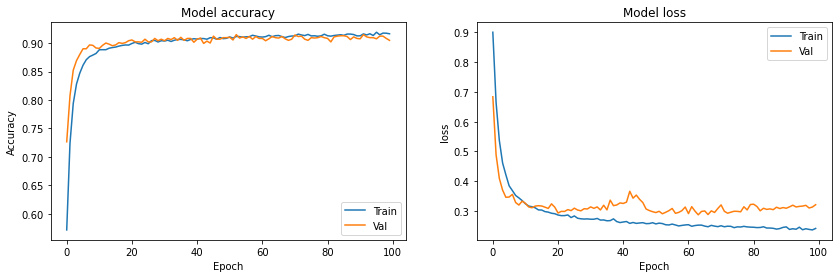

In [64]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set but from the loss plots, the model has slightly higher losses on the validation set compared to the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is an 8 layer fully connected Neural Network. it has 1 input layer, 4 hidden layers with Relu activation function, 2 dropout layers to prevent overfitting and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

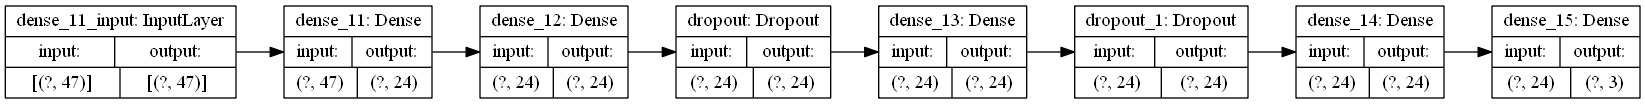

In [65]:
plot_model(model_4, show_shapes=True, rankdir="LR")

In [66]:
print(model_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 24)                1152      
_________________________________________________________________
dense_12 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_15 (Dense)             (None, 3)                

#### Evaluating the model on the test set

In [67]:
%%time
y_pred_test = np.argmax(model_4.predict(X_test), axis=-1)

Wall time: 109 ms


In [68]:
print_accuracy(model_4, y_train, y_val, y_test)

Train Set Accuracy: 	 91.82
Train Set Precision: 	 0.92
Train Set Recall: 	 0.92
Train Set F score: 	 0.92

Val Set Accuracy: 	 90.51
Val Set Precision: 	 0.91
Val Set Recall: 	 0.9
Val Set F score: 	 0.91

Test Set Accuracy: 	 90.24
Test Set Precision: 	 0.9
Test Set Recall: 	 0.9
Test Set F score: 	 0.9



In [69]:
history_list.append(history)

## Building the Recurrent Models

### <span style="color:blue">Network description</span>

We built 2 recurrent neural network models one **simple RNN** and one **LSTM** model.

Recurrent Neural Networks are a generalization of feedforward neural network that has an internal memory. After producing the output, it is copied and sent back into the recurrent network. For making a decision, it considers the current input and the output that it has learned from the previous input. RNN can model sequence of data so that each sample can be assumed to be dependent on previous ones and is good for modelling time series data. RNN has certain disadvantages such as difficulty in training, and gradient vanishing or exploding problem. RNNs also have difficulty in learning long range dependencies

Long Short-Term Memory (LSTM) networks are a modified version of recurrent neural networks, which makes it easier to remember past data in memory. The vanishing gradient problem of RNN is resolved here. 

Also, **softmax** activation was used for all the output layers as the the problem is a multiclass classification and softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1.

The loss function used for all models was **SparseCategoricalCrossentropy** which is excellent for multiclass labels in floating point format.


- The **first reccurent model** is a 5 layer Simple Recurrent Neural Network (1 input layer, 1 RNN layer, 2 hidden layers and 1 output layer).
- The **second model** is a 5 layer LSTM Neural Network (1 input layer, 1 LSTM layer, 2 hidden layers and 1 output layer).

All hidden layers in the recurrent models use **Relu activation** and the models were trained with a batch size of **64** through **100** epochs

#### Preparing the data for Recurrent models
Recurrent models expect in 3 dimensional matrix of features (*no of samples* x *number of features* x *batch size*) so the data will have to be prepared for the recurrent models.

In [70]:
# Reshaping the data
rnn_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
rnn_val = X_val.reshape(len(X_val), X_train.shape[1], 1)
rnn_test = X_test.reshape(len(X_test), X_train.shape[1], 1)

### <span style="color:blue">Model 5: 1 input layer, 1 RNN layer, 2 hidden layers and 1 output layer</span>

#### Building and training the model

In [71]:
model_5 = Sequential()

# Creating the input layer and RNN layer
model_5.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))

#Adding first hidden layer
model_5.add(Dense(32, activation='relu'))

#Adding second hidden layer
model_5.add(Dense(32, activation='relu'))

#Adding the output layer
model_5.add(Dense(3, activation='softmax'))

model_5.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_5.fit(rnn_train, y_train, validation_data = (rnn_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

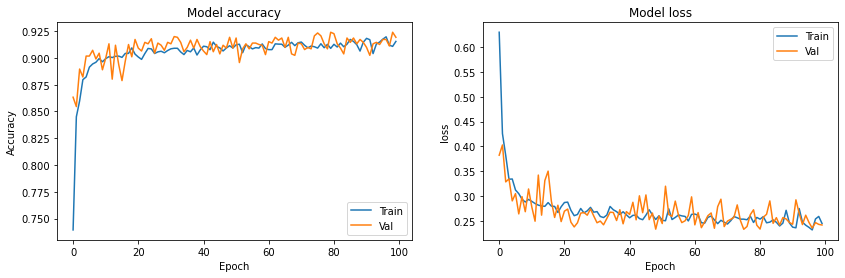

In [73]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set. The loss plot also shows that the model performs as well on the validation set as it does on the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is a 5 layer Simple Recurrent Neural Network. It has 1 input layer, 1 RNN layer, 2 hidden layers with Relu activation and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

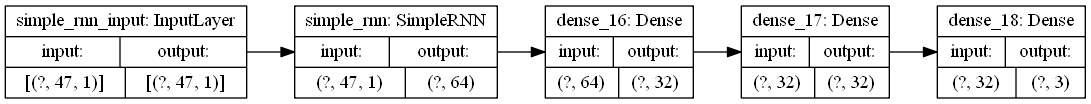

In [74]:
plot_model(model_5, show_shapes=True, rankdir="LR")

In [75]:
print(model_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 99        
Total params: 7,459
Trainable params: 7,459
Non-trainable params: 0
_________________________________________________________________
None


#### Evaluating the model on the test set

In [76]:
%%time
y_pred_test = np.argmax(model_5.predict(rnn_test), axis=-1)

Wall time: 333 ms


In [77]:
print_accuracy(model_5, y_train, y_val, y_test, mode=1)

Train Set Accuracy: 	 91.5
Train Set Precision: 	 0.92
Train Set Recall: 	 0.91
Train Set F score: 	 0.91

Val Set Accuracy: 	 91.92
Val Set Precision: 	 0.92
Val Set Recall: 	 0.92
Val Set F score: 	 0.92

Test Set Accuracy: 	 90.38
Test Set Precision: 	 0.9
Test Set Recall: 	 0.9
Test Set F score: 	 0.9



In [78]:
history_list.append(history)

### <span style="color:blue">Model 6: 1 input layer, 1 LSTM layer, 2 hidden layers and 1 output layer</span>

#### Building and training the model

In [79]:
model_6 = Sequential()

# Creating the input layer and LSTM layer
model_6.add(LSTM(64, input_shape=(X_train.shape[1], 1)))

#Adding first hidden layer
model_6.add(Dense(32, activation='relu'))

#Adding second hidden layer
model_6.add(Dense(32, activation='relu'))

#Adding the output layer
model_6.add(Dense(3, activation='softmax'))

model_6.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [ ]:
%%time
#Fitting the classifier to the training set
history = model_6.fit(rnn_train, y_train, validation_data = (rnn_val, y_val), batch_size=64, epochs=100)

#### Analysing the model training and loss plots

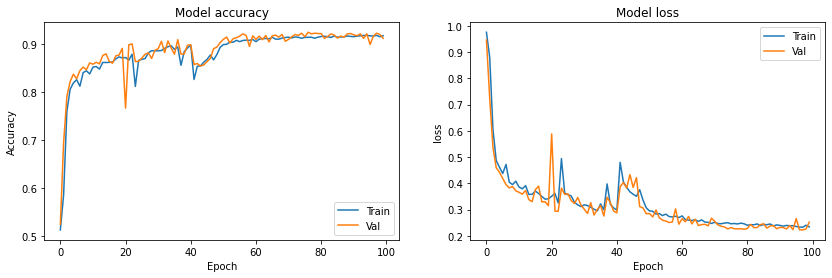

In [81]:
accuracy_loss_plot(history)

From the accuracy plot, the model performs well on both the training set and the validation set. The loss plot also shows that the model performs as well on the validation set as it does on the training set.

### <span style="color:blue">Network description with text and figures</span>

This model is a 5 layer LSTM Neural Network. it has 1 input layer, 1 LSTM layer, 2 hidden layers with Relu activation and 1 output layer. The output layer uses softmax which is suitable for multiclass classification.

The code is compiled using Adam optimizer, The loss is measured using SparseCategoricalCrossentropy and the performance measure is Accuracy.

The model is trained with a batch size of 64 for 100 epochs.

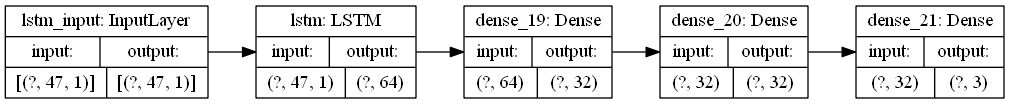

In [82]:
plot_model(model_6, show_shapes=True, rankdir="LR")

In [83]:
print(model_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 99        
Total params: 20,131
Trainable params: 20,131
Non-trainable params: 0
_________________________________________________________________
None


#### Evaluating the model on the test set

In [84]:
%%time
y_pred_test = np.argmax(model_6.predict(rnn_test), axis=-1)

Wall time: 825 ms


In [85]:
print_accuracy(model_6, y_train, y_val, y_test, mode=1)

Train Set Accuracy: 	 91.19
Train Set Precision: 	 0.91
Train Set Recall: 	 0.91
Train Set F score: 	 0.91

Val Set Accuracy: 	 91.18
Val Set Precision: 	 0.91
Val Set Recall: 	 0.91
Val Set F score: 	 0.91

Test Set Accuracy: 	 91.45
Test Set Precision: 	 0.91
Test Set Recall: 	 0.91
Test Set F score: 	 0.91



In [86]:
history_list.append(history)